In [1]:
import pandas as pd

df = pd.read_csv('../use_this_data/rest_data_last.csv')

df.head()

,category,text
0,arts,rob delaney vir das galen hopper samson kayo g...
1,arts,andris nelsons conducts a joint concert of the...
2,arts,warner music group has brought on sherry tan t...
3,arts,adele will explore what she s been going throu...
4,arts,you are using an older browser version. please...


In [ ]:
from nltk.corpus import stopwords, words
from nltk import WordNetLemmatizer, word_tokenize
import re
# Download NLTK resources (run once)
import nltk
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
english_vocab = set(w.lower() for w in words.words())

def clean_text(text):
    """
    Cleans and preprocesses the input text, removing
    URLs, HTML tags, punctuation, stopwords, and any word
    that is not in a large English vocabulary set.
    """
    # Step 1: Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Step 2: Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Step 3: Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Step 4: Convert to lowercase
    text = text.lower()
    
    # Step 5: Tokenize text into words
    tokens = word_tokenize(text)
    
    # Step 6: Remove stopwords and short tokens
    tokens = [word for word in tokens if word not in stop_words and len(word) >= 3]
    
    tokens = [word for word in tokens if len(word) >= 3]
    
    # Step 7: Lemmatize words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Step 8: Keep only English words (based on nltk.corpus.words)
    tokens = [word for word in tokens if word in english_vocab]

    # Step 9: Join tokens back into a single string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Example usage
df["clean_text"] = df["text"].apply(clean_text)

df.head()

In [24]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["category_encoded"] = label_encoder.fit_transform(df["category"].values)

# Display the updated DataFrame to verify the new column
print(df.head())

  category                                               text  \
0     arts  rob delaney vir das galen hopper samson kayo g...   
1     arts  andris nelsons conducts a joint concert of the...   
2     arts  warner music group has brought on sherry tan t...   
3     arts  adele will explore what she s been going throu...   
4     arts  you are using an older browser version. please...   

                                          clean_text  category_encoded  
0  rob da galen hopper samson kayo guz khan nick ...                 0  
1  nelson conduct joint concert boston symphony o...                 0  
2  warner music group brought sherry tan head mus...                 0  
3  explore going new album set explore going new ...                 0  
4  older browser version please use version best ...                 0  


In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from cleanlab import Datalab
from cleanlab.internal.multilabel_utils import int2onehot, onehot2int
import matplotlib.pyplot as plt

text = df["clean_text"].tolist()

label_encoder = LabelEncoder()
# y = pd.Series(df["category_encoded"])
y = df["category_encoded"].values

# 2. TF-IDF vectorization
vectorizer = TfidfVectorizer(
    analyzer='word',
    token_pattern=r'(?u)\b\w\w+\b',
    lowercase=True,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8,
    sublinear_tf=True,
    norm='l2',
    smooth_idf=True
)
X = vectorizer.fit_transform(text)


# lab = Datalab(df, label_column='category', task='multilabel')
# lab.find_issues(pred_probs=pred_probs, features=features)
# 
# lab.report()


<class 'numpy.ndarray'>
(5292,)


In [39]:
from cleanlab.classification import CleanLearning
from sklearn.linear_model import LogisticRegression

# 4. Use CleanLearning

clf = LogisticRegression(max_iter=300)
cleanl = CleanLearning(clf=clf, cv_n_folds=3, seed=42)

cleanl.fit(X, y)

# 5. Identify potential label issues

ranked_indices = cleanl.find_label_issues(labels=y, X=X)

# ranked_indices = ranked_indices.flatten()  # or list(ranked_indices.ravel())
ranked_indices = ranked_indices.iloc[:, 0].to_numpy().flatten()

# 6. Inspect suspicious examples
df_suspects = df.loc[ranked_indices].copy()
print("Potential label issues:")
print(df_suspects)


Potential label issues:
     category                                               text  \
5        arts  paris reuters french nightclubs will be allowe...   
11       arts  as soon as the waitsfield west sidewalk is com...   
13       arts  mirolin parker model glass sliding doors for a...   
14       arts  south dakota beef producers raise money for a ...   
15       arts  seiko watches for sale. both comes on strapcod...   
...       ...                                                ...   
5257  weather  in the last round of covid 19 tier assignments...   
5264  weather  a giant mount rushmore style sculpture made ou...   
5274  weather  taiwan s tsmc a leader in water management  sa...   
5275  weather  at the risk of being struck by lightning i got...   
5284  weather  opioids photo by files postmedia . algoma publ...   

                                             clean_text  category_encoded  
5     paris french open july onwards said government...                 0  
11    s

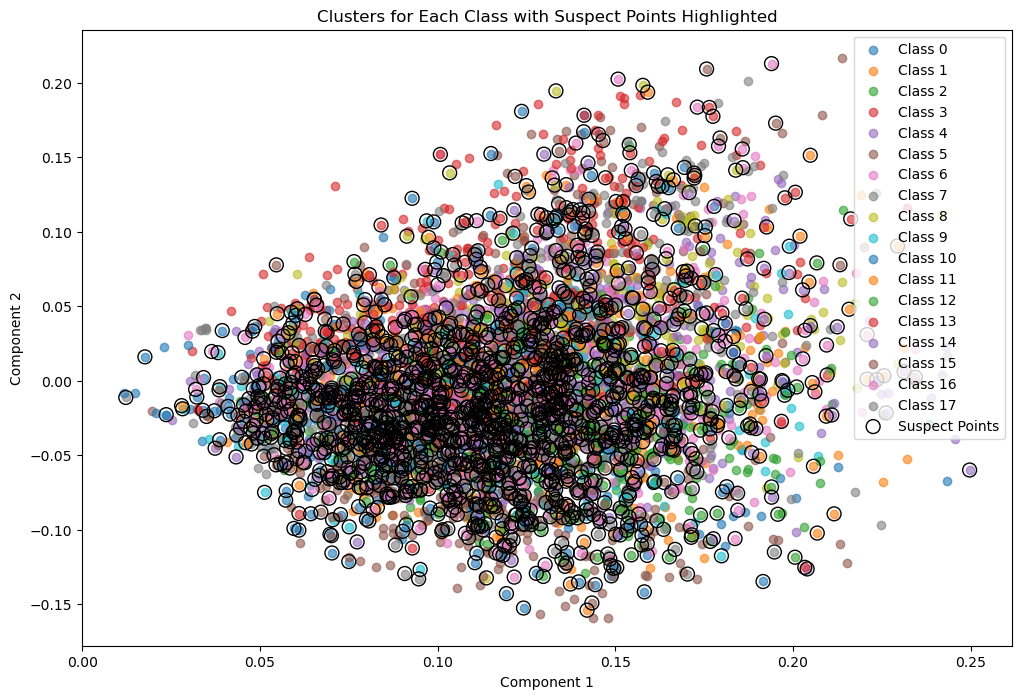

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD

# Reduce dimensionality to 2D for visualization.
svd = TruncatedSVD(n_components=2, random_state=42)
X_reduced = svd.fit_transform(X)

# Create a scatter plot where each class gets its own color.
plt.figure(figsize=(12, 8))
unique_classes = np.unique(y)
for c in unique_classes:
    # Create a mask for data points of the current class.
    mask = (y == c)
    plt.scatter(
        X_reduced[mask, 0],
        X_reduced[mask, 1],
        label=f"Class {c}",
        alpha=0.6
    )

# Overlay the suspect points.
# Here, 'ranked_indices' is assumed to be a 1D array (or list) of indices.
plt.scatter(
    X_reduced[ranked_indices, 0],
    X_reduced[ranked_indices, 1],
    facecolors='none',   # unfilled marker
    edgecolors='black',  # black outline for suspect points
    s=100,
    label='Suspect Points'
)

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Clusters for Each Class with Suspect Points Highlighted")
plt.legend()
plt.show()


In [43]:
# Create a new DataFrame without the suspect rows
df_clean = df.drop(index=df_suspects.index)

# Optional: Reset the index if needed
df_clean = df_clean.reset_index(drop=True)

print("Clean DataFrame:")
print(df_clean)


Clean DataFrame:
     category                                               text  \
0        arts  rob delaney vir das galen hopper samson kayo g...   
1        arts  andris nelsons conducts a joint concert of the...   
2        arts  warner music group has brought on sherry tan t...   
3        arts  adele will explore what she s been going throu...   
4        arts  you are using an older browser version. please...   
...       ...                                                ...   
3550  weather  orangeburg . this evening in orangeburg cloudy...   
3551  weather  national basketball association north american...   
3552  weather  las vegas ap the southwest continued to bake s...   
3553  weather  here is today s weather outlook for jun. 25 20...   
3554  weather  singapore about 10000 years ago sea levels in ...   

                                             clean_text  category_encoded  
0     rob da galen hopper samson kayo guz khan nick ...                 0  
1     nelson c

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

x = df_clean["clean_text"]
y = df_clean["category"]

# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# 2. TF-IDF vectorization
vectorizer = TfidfVectorizer(
    analyzer='word',
    token_pattern=r'(?u)\b\w\w+\b',
    lowercase=True,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8,
    max_features=50000,
    sublinear_tf=True,
    norm='l2',
    smooth_idf=True
)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# 3. Define parameter distributions for RandomizedSearchCV
param_distributions = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [5, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
    "class_weight": ["balanced", None, "balanced_subsample"],
}

# 4. Base RandomForest model
rf = RandomForestClassifier(random_state=42)

# 5. RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# 6. Fit random search on training data
random_search.fit(X_train_vectorized, y_train)

# 7. Get the best model and hyperparameters
best_rf = random_search.best_estimator_
print("Best Hyperparameters found by RandomizedSearchCV:")
print(random_search.best_params_)

# 8. Predict on test data (standard prediction, no custom threshold)
y_pred = best_rf.predict(X_test_vectorized)

# 9. Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Hyperparameters found by RandomizedSearchCV:
{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': True}

Accuracy: 0.6947960618846695

Classification Report:
               precision    recall  f1-score   support

         arts       0.82      0.64      0.72        50
        crime       0.76      0.85      0.80        53
     disaster       0.69      0.59      0.64        46
      economy       0.61      0.61      0.61        33
    education       0.60      0.94      0.73        54
environmental       0.92      0.78      0.84        45
       health       0.67      0.83      0.74        41
humanInterest       0.79      0.53      0.63        36
       labour       0.78      0.78      0.78        49
    lifestyle       0.55      0.59      0.57        27
        other       0.46      0.26      0.33        23
     po